In [12]:
import numpy as np
from tqdm.notebook import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import PIL.Image as Image
import os
import glob
import torchvision.models as models
import copy
import time

In [13]:
if torch.cuda.is_available():
    print("The code will run on GPU.")
else:
    print("The code will run on CPU. Go to Edit->Notebook Settings and choose GPU as the hardware accelerator")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

The code will run on GPU.


# Network

In [14]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.convolutional = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )

        self.fully_connected = nn.Sequential(
                nn.Linear(64*4*4*4*4, 64),
                nn.ReLU(),
                nn.Linear(64, 2),
                nn.LogSoftmax(dim=1)
        )

    def forward(self, x):
        x = self.convolutional(x)

        x = x.view(x.size(0), -1)
        x = self.fully_connected(x)

        return x


# Hotdog class

In [15]:
class Hotdog_NotHotdog(torch.utils.data.Dataset):
    def __init__(self, train, transform, data_path='/dtu/datasets1/02514/hotdog_nothotdog'):
        'Initialization'
        self.transform = transform
        data_path = os.path.join(data_path, 'train' if train else 'test')
        image_classes = [os.path.split(d)[1] for d in glob.glob(data_path +'/*') if os.path.isdir(d)]
        image_classes.sort()
        self.name_to_label = {c: id for id, c in enumerate(image_classes)}
        self.image_paths = glob.glob(data_path + '/*/*.jpg')
        
    def __len__(self):
        'Returns the total number of samples'
        return len(self.image_paths)

    def __getitem__(self, idx):
        'Generates one sample of data'
        image_path = self.image_paths[idx]
        
        image = Image.open(image_path)
        c = os.path.split(os.path.split(image_path)[0])[1]
        y = self.name_to_label[c]
        X = self.transform(image)
        return X, y

# Visualize the model predictions function

In [16]:
def visualize_model(model, num_images=15):
    was_training = model.training
    model.eval()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(test_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            fig, axs = plt.subplots(3,5, figsize=(20,10))
            c = 0
            # plot 15 images in a grid 3x5
            for j in range(3):
                for k in range(5):
                    c += 1
                    pred = preds[c]
                    label = labels[c]
                    
                    axs[j,k].axis('off')
                    if pred == 0:
                        axs[j,k].set_title(f'Predicted: hot dog \nClass: {label}')
                    else:
                        axs[j,k].set_title(f'Predicted: NOT hot dog \nClass: {label}')

                    # RGB
                    # img = inputs.cpu().data[c]
                    # img = np.asarray(img).transpose(1,2,0)
                    # axs[j,k].imshow(img)
                    # GRAY
                    img = inputs.cpu().data[c].numpy()[0]
                    axs[j,k].imshow(img, "gray")

                    if c == num_images:
                        model.train(mode=was_training)
                        plt.show()
                        return
            
        model.train(mode=was_training)

# Load and show some images

In [17]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
trans = transforms.Compose([transforms.Resize(256), 
                            transforms.CenterCrop(224), 
                            transforms.ToTensor(),
                            normalize
                            ])

In [18]:
batch_size = 64

trainset = Hotdog_NotHotdog(train=True, transform=trans)
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=3)
testset = Hotdog_NotHotdog(train=False, transform=trans)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=3)

Image shape: (224, 224)


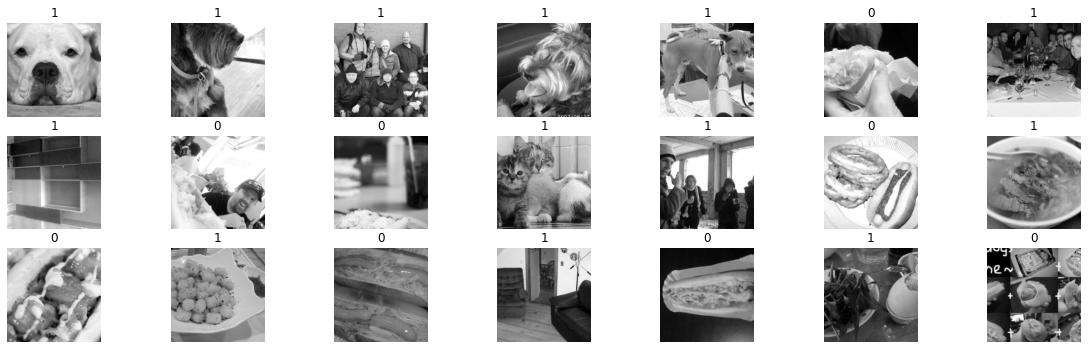

In [19]:
images, labels = next(iter(train_loader))
plt.figure(figsize=(20,10))

print(f"Image shape: {images[0].numpy()[0].shape}")

for i in range(21):
    plt.subplot(5,7,i+1)
    plt.imshow(images[i].numpy()[0], 'gray')
    plt.title(labels[i].item())
    plt.axis('off')

# Data augmentation and different optimizers

## Train function

In [23]:
#We define the training as a function so we can easily re-use it.
def train(model, optimizer, num_epochs=10):
    out_dict = {'train_acc': [],
              'test_acc': [],
              'train_loss': [],
              'test_loss': []}
  
    for epoch in tqdm(range(num_epochs), unit='epoch'):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)
        model.train()
        #For each epoch
        train_correct = 0
        train_loss = []
        for minibatch_no, (data, target) in tqdm(enumerate(train_loader), total=len(train_loader)):
            data, target = data.to(device), target.to(device)
            #Zero the gradients computed for each weight
            optimizer.zero_grad()
            #Forward pass your image through the network
            output = model(data)
            #Compute the loss
            loss = F.nll_loss(output, target)
            #Backward pass through the network
            loss.backward()
            #Update the weights
            optimizer.step()

            train_loss.append(loss.item())
            #Compute how many wenre correctly classified
            predicted = output.argmax(1)
            train_correct += (target==predicted).sum().cpu().item()

        #Compute the test accuracy
        test_loss = []
        test_correct = 0
        model.eval()
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            with torch.no_grad():
                output = model(data)
            test_loss.append(F.nll_loss(output, target).cpu().item())
            predicted = output.argmax(1)
            test_correct += (target==predicted).sum().cpu().item()
            
        out_dict['train_acc'].append(train_correct/len(trainset))
        out_dict['test_acc'].append(test_correct/len(testset))
        out_dict['train_loss'].append(np.mean(train_loss))
        out_dict['test_loss'].append(np.mean(test_loss))
        print(f"Loss train: {np.mean(train_loss):.3f}\t test: {np.mean(test_loss):.3f}\t",
              f"Accuracy train: {out_dict['train_acc'][-1]*100:.1f}%\t test: {out_dict['test_acc'][-1]*100:.1f}%")

    return out_dict

## Data augmentation

In [24]:
size = 128
aug_transforms = [
    transforms.Compose([transforms.Resize((size, size)), 
                        transforms.ToTensor()]),
    transforms.Compose([transforms.Resize((size*2, size*2)),
                        transforms.RandomCrop(size), 
                        transforms.ToTensor()]),                        
    transforms.Compose([transforms.Resize((size, size)),
                        transforms.RandomHorizontalFlip(), 
                        transforms.ToTensor()]),  
    transforms.Compose([transforms.Resize((size, size)),
                        transforms.RandomRotation((-45, 45)), 
                        transforms.ToTensor()]),   
    transforms.Compose([transforms.Resize((size, size)), 
                        transforms.ToTensor(),
                        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])]),
    transforms.Compose([transforms.Resize((size*2, size*2)),
                        transforms.RandomCrop(size), 
                        transforms.ToTensor(),
                        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])]),                      
    transforms.Compose([transforms.Resize((size, size)),
                        transforms.RandomHorizontalFlip(), 
                        transforms.ToTensor(),
                        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])]),
    transforms.Compose([transforms.Resize((size, size)),
                        transforms.RandomRotation((-45, 45)), 
                        transforms.ToTensor(),
                        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])
]

## Train model

In [25]:
model_results = {
    'adam': [],
    'sgd': []
    }
batch_size = 64
for trans in aug_transforms:
    trainset = Hotdog_NotHotdog(train=True, transform=trans)
    train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=3)
    testset = Hotdog_NotHotdog(train=False, transform=trans)
    test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=3)

    model = Net()
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters())
    model_results['adam'].append(train(model, optimizer))

for trans in aug_transforms:
    trainset = Hotdog_NotHotdog(train=True, transform=trans)
    train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=3)
    testset = Hotdog_NotHotdog(train=False, transform=trans)
    test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=3)

    model = Net()
    model.to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
    model_results['sgd'].append(train(model, optimizer))

  0%|          | 0/10 [00:00<?, ?epoch/s]

Epoch 0/9
----------


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.616	 test: 0.570	 Accuracy train: 66.1%	 test: 70.3%
Epoch 1/9
----------


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.526	 test: 0.538	 Accuracy train: 75.8%	 test: 73.6%
Epoch 2/9
----------


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.497	 test: 0.525	 Accuracy train: 76.7%	 test: 74.8%
Epoch 3/9
----------


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.461	 test: 0.515	 Accuracy train: 79.4%	 test: 75.7%
Epoch 4/9
----------


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.424	 test: 0.540	 Accuracy train: 81.1%	 test: 75.0%
Epoch 5/9
----------


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.398	 test: 0.541	 Accuracy train: 82.7%	 test: 74.8%
Epoch 6/9
----------


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.357	 test: 0.534	 Accuracy train: 85.0%	 test: 76.9%
Epoch 7/9
----------


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.306	 test: 0.555	 Accuracy train: 87.8%	 test: 77.3%
Epoch 8/9
----------


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.279	 test: 0.554	 Accuracy train: 88.8%	 test: 76.2%
Epoch 9/9
----------


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.227	 test: 0.631	 Accuracy train: 91.4%	 test: 75.5%


  0%|          | 0/10 [00:00<?, ?epoch/s]

Epoch 0/9
----------


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.654	 test: 0.604	 Accuracy train: 61.6%	 test: 67.7%
Epoch 1/9
----------


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.601	 test: 0.602	 Accuracy train: 69.2%	 test: 69.3%
Epoch 2/9
----------


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.592	 test: 0.571	 Accuracy train: 72.1%	 test: 70.8%
Epoch 3/9
----------


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.547	 test: 0.579	 Accuracy train: 73.4%	 test: 71.2%
Epoch 4/9
----------


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.543	 test: 0.564	 Accuracy train: 73.7%	 test: 72.3%
Epoch 5/9
----------


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.513	 test: 0.546	 Accuracy train: 75.3%	 test: 73.4%
Epoch 6/9
----------


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.516	 test: 0.545	 Accuracy train: 75.5%	 test: 72.7%
Epoch 7/9
----------


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.515	 test: 0.574	 Accuracy train: 75.6%	 test: 72.8%
Epoch 8/9
----------


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.513	 test: 0.541	 Accuracy train: 75.5%	 test: 73.0%
Epoch 9/9
----------


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.505	 test: 0.537	 Accuracy train: 76.9%	 test: 75.2%


  0%|          | 0/10 [00:00<?, ?epoch/s]

Epoch 0/9
----------


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.657	 test: 0.560	 Accuracy train: 59.0%	 test: 72.6%
Epoch 1/9
----------


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.544	 test: 0.560	 Accuracy train: 74.1%	 test: 72.2%
Epoch 2/9
----------


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.524	 test: 0.584	 Accuracy train: 75.8%	 test: 71.6%
Epoch 3/9
----------


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.512	 test: 0.575	 Accuracy train: 75.6%	 test: 70.8%
Epoch 4/9
----------


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.485	 test: 0.516	 Accuracy train: 77.4%	 test: 75.6%
Epoch 5/9
----------


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.463	 test: 0.515	 Accuracy train: 78.4%	 test: 74.4%
Epoch 6/9
----------


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.469	 test: 0.502	 Accuracy train: 78.7%	 test: 76.6%
Epoch 7/9
----------


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.441	 test: 0.504	 Accuracy train: 80.4%	 test: 76.8%
Epoch 8/9
----------


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.415	 test: 0.498	 Accuracy train: 80.9%	 test: 76.2%
Epoch 9/9
----------


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.392	 test: 0.481	 Accuracy train: 82.2%	 test: 76.8%


  0%|          | 0/10 [00:00<?, ?epoch/s]

Epoch 0/9
----------


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.683	 test: 0.613	 Accuracy train: 57.9%	 test: 68.3%
Epoch 1/9
----------


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.560	 test: 0.603	 Accuracy train: 72.7%	 test: 69.9%
Epoch 2/9
----------


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.522	 test: 0.555	 Accuracy train: 75.4%	 test: 72.6%
Epoch 3/9
----------


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.543	 test: 0.571	 Accuracy train: 73.2%	 test: 73.5%
Epoch 4/9
----------


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.508	 test: 0.528	 Accuracy train: 76.4%	 test: 74.2%
Epoch 5/9
----------


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.482	 test: 0.492	 Accuracy train: 78.7%	 test: 76.5%
Epoch 6/9
----------


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.468	 test: 0.513	 Accuracy train: 78.1%	 test: 75.5%
Epoch 7/9
----------


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.447	 test: 0.478	 Accuracy train: 80.3%	 test: 77.7%
Epoch 8/9
----------


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.427	 test: 0.493	 Accuracy train: 81.2%	 test: 77.7%
Epoch 9/9
----------


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.424	 test: 0.474	 Accuracy train: 81.8%	 test: 78.1%


  0%|          | 0/10 [00:00<?, ?epoch/s]

Epoch 0/9
----------


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.649	 test: 0.566	 Accuracy train: 60.9%	 test: 72.8%
Epoch 1/9
----------


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.537	 test: 0.534	 Accuracy train: 74.4%	 test: 73.7%
Epoch 2/9
----------


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.487	 test: 0.530	 Accuracy train: 77.1%	 test: 74.4%
Epoch 3/9
----------


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.475	 test: 0.538	 Accuracy train: 78.7%	 test: 73.7%
Epoch 4/9
----------


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.440	 test: 0.524	 Accuracy train: 80.2%	 test: 75.8%
Epoch 5/9
----------


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.410	 test: 0.513	 Accuracy train: 82.0%	 test: 77.3%
Epoch 6/9
----------


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.389	 test: 0.537	 Accuracy train: 82.7%	 test: 76.0%
Epoch 7/9
----------


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.324	 test: 0.553	 Accuracy train: 86.3%	 test: 77.1%
Epoch 8/9
----------


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.275	 test: 0.537	 Accuracy train: 89.0%	 test: 77.4%
Epoch 9/9
----------


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.212	 test: 0.594	 Accuracy train: 92.2%	 test: 77.1%


  0%|          | 0/10 [00:00<?, ?epoch/s]

Epoch 0/9
----------


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.664	 test: 0.645	 Accuracy train: 58.1%	 test: 63.9%
Epoch 1/9
----------


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.594	 test: 0.586	 Accuracy train: 70.6%	 test: 69.8%
Epoch 2/9
----------


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.557	 test: 0.628	 Accuracy train: 72.2%	 test: 67.2%
Epoch 3/9
----------


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.550	 test: 0.550	 Accuracy train: 73.8%	 test: 71.7%
Epoch 4/9
----------


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.526	 test: 0.619	 Accuracy train: 74.8%	 test: 68.2%
Epoch 5/9
----------


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.527	 test: 0.532	 Accuracy train: 74.5%	 test: 73.4%
Epoch 6/9
----------


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.502	 test: 0.539	 Accuracy train: 75.6%	 test: 74.3%
Epoch 7/9
----------


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.487	 test: 0.520	 Accuracy train: 76.9%	 test: 75.1%
Epoch 8/9
----------


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.485	 test: 0.544	 Accuracy train: 77.9%	 test: 74.0%
Epoch 9/9
----------


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.467	 test: 0.525	 Accuracy train: 78.6%	 test: 75.3%


  0%|          | 0/10 [00:00<?, ?epoch/s]

Epoch 0/9
----------


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.635	 test: 0.659	 Accuracy train: 63.5%	 test: 60.9%
Epoch 1/9
----------


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.558	 test: 0.546	 Accuracy train: 72.0%	 test: 73.6%
Epoch 2/9
----------


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.503	 test: 0.530	 Accuracy train: 74.7%	 test: 73.8%
Epoch 3/9
----------


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.478	 test: 0.506	 Accuracy train: 77.1%	 test: 76.0%
Epoch 4/9
----------


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.442	 test: 0.504	 Accuracy train: 79.2%	 test: 76.2%
Epoch 5/9
----------


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.412	 test: 0.497	 Accuracy train: 81.0%	 test: 77.6%
Epoch 6/9
----------


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.384	 test: 0.493	 Accuracy train: 82.5%	 test: 76.4%
Epoch 7/9
----------


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.360	 test: 0.529	 Accuracy train: 84.6%	 test: 76.9%
Epoch 8/9
----------


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.318	 test: 0.499	 Accuracy train: 86.6%	 test: 78.5%
Epoch 9/9
----------


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.299	 test: 0.513	 Accuracy train: 87.5%	 test: 76.5%


  0%|          | 0/10 [00:00<?, ?epoch/s]

Epoch 0/9
----------


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.625	 test: 0.613	 Accuracy train: 64.7%	 test: 66.8%
Epoch 1/9
----------


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.524	 test: 0.542	 Accuracy train: 74.8%	 test: 72.8%
Epoch 2/9
----------


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.510	 test: 0.533	 Accuracy train: 75.9%	 test: 73.5%
Epoch 3/9
----------


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.478	 test: 0.574	 Accuracy train: 77.1%	 test: 70.2%
Epoch 4/9
----------


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.466	 test: 0.511	 Accuracy train: 78.1%	 test: 74.5%
Epoch 5/9
----------


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.464	 test: 0.562	 Accuracy train: 78.1%	 test: 74.4%
Epoch 6/9
----------


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.439	 test: 0.470	 Accuracy train: 80.3%	 test: 77.2%
Epoch 7/9
----------


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.430	 test: 0.507	 Accuracy train: 79.7%	 test: 76.7%
Epoch 8/9
----------


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.403	 test: 0.473	 Accuracy train: 82.2%	 test: 78.9%
Epoch 9/9
----------


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.389	 test: 0.482	 Accuracy train: 82.4%	 test: 77.8%


  0%|          | 0/10 [00:00<?, ?epoch/s]

Epoch 0/9
----------


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.689	 test: 0.686	 Accuracy train: 53.2%	 test: 57.8%
Epoch 1/9
----------


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.692	 test: 0.706	 Accuracy train: 50.3%	 test: 48.1%
Epoch 2/9
----------


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.671	 test: 0.674	 Accuracy train: 58.7%	 test: 54.0%
Epoch 3/9
----------


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.643	 test: 0.635	 Accuracy train: 65.2%	 test: 70.4%
Epoch 4/9
----------


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.587	 test: 0.558	 Accuracy train: 72.3%	 test: 70.3%
Epoch 5/9
----------


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.661	 test: 0.588	 Accuracy train: 60.8%	 test: 70.0%
Epoch 6/9
----------


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.578	 test: 0.562	 Accuracy train: 72.2%	 test: 71.4%
Epoch 7/9
----------


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.567	 test: 0.579	 Accuracy train: 71.8%	 test: 69.4%
Epoch 8/9
----------


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.530	 test: 0.562	 Accuracy train: 75.5%	 test: 72.1%
Epoch 9/9
----------


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.524	 test: 0.579	 Accuracy train: 75.3%	 test: 69.8%


  0%|          | 0/10 [00:00<?, ?epoch/s]

Epoch 0/9
----------


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.693	 test: 0.684	 Accuracy train: 52.0%	 test: 63.4%
Epoch 1/9
----------


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.681	 test: 0.691	 Accuracy train: 58.0%	 test: 54.0%
Epoch 2/9
----------


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.675	 test: 0.661	 Accuracy train: 60.1%	 test: 62.6%
Epoch 3/9
----------


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.670	 test: 0.678	 Accuracy train: 60.7%	 test: 60.4%
Epoch 4/9
----------


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.651	 test: 0.617	 Accuracy train: 64.6%	 test: 67.3%
Epoch 5/9
----------


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.590	 test: 0.629	 Accuracy train: 70.8%	 test: 65.1%
Epoch 6/9
----------


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.608	 test: 0.584	 Accuracy train: 69.1%	 test: 70.6%
Epoch 7/9
----------


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.579	 test: 0.571	 Accuracy train: 71.9%	 test: 70.9%
Epoch 8/9
----------


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.594	 test: 0.586	 Accuracy train: 69.7%	 test: 70.9%
Epoch 9/9
----------


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.566	 test: 0.567	 Accuracy train: 72.1%	 test: 71.2%


  0%|          | 0/10 [00:00<?, ?epoch/s]

Epoch 0/9
----------


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.692	 test: 0.700	 Accuracy train: 52.2%	 test: 48.1%
Epoch 1/9
----------


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.681	 test: 0.665	 Accuracy train: 59.0%	 test: 69.3%
Epoch 2/9
----------


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.649	 test: 0.681	 Accuracy train: 64.9%	 test: 57.3%
Epoch 3/9
----------


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.651	 test: 0.587	 Accuracy train: 65.3%	 test: 72.2%
Epoch 4/9
----------


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.642	 test: 0.551	 Accuracy train: 64.2%	 test: 71.4%
Epoch 5/9
----------


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.555	 test: 0.553	 Accuracy train: 73.7%	 test: 72.2%
Epoch 6/9
----------


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.528	 test: 0.543	 Accuracy train: 75.3%	 test: 72.8%
Epoch 7/9
----------


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.527	 test: 0.539	 Accuracy train: 75.0%	 test: 73.6%
Epoch 8/9
----------


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.537	 test: 0.561	 Accuracy train: 74.4%	 test: 70.9%
Epoch 9/9
----------


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.524	 test: 0.575	 Accuracy train: 74.9%	 test: 72.2%


  0%|          | 0/10 [00:00<?, ?epoch/s]

Epoch 0/9
----------


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.692	 test: 0.692	 Accuracy train: 52.2%	 test: 49.6%
Epoch 1/9
----------


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.690	 test: 0.684	 Accuracy train: 53.7%	 test: 63.4%
Epoch 2/9
----------


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.679	 test: 0.682	 Accuracy train: 58.9%	 test: 55.3%
Epoch 3/9
----------


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.669	 test: 0.610	 Accuracy train: 65.9%	 test: 69.1%
Epoch 4/9
----------


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.615	 test: 0.635	 Accuracy train: 67.2%	 test: 64.6%
Epoch 5/9
----------


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.594	 test: 0.684	 Accuracy train: 70.0%	 test: 55.5%
Epoch 6/9
----------


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.604	 test: 0.583	 Accuracy train: 69.4%	 test: 72.2%
Epoch 7/9
----------


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.539	 test: 0.549	 Accuracy train: 74.7%	 test: 71.4%
Epoch 8/9
----------


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.548	 test: 0.538	 Accuracy train: 73.6%	 test: 73.3%
Epoch 9/9
----------


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.541	 test: 0.544	 Accuracy train: 74.4%	 test: 72.1%


  0%|          | 0/10 [00:00<?, ?epoch/s]

Epoch 0/9
----------


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.684	 test: 0.654	 Accuracy train: 56.6%	 test: 65.4%
Epoch 1/9
----------


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.626	 test: 0.714	 Accuracy train: 65.4%	 test: 61.5%
Epoch 2/9
----------


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.655	 test: 0.697	 Accuracy train: 62.2%	 test: 48.1%
Epoch 3/9
----------


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.685	 test: 0.670	 Accuracy train: 52.4%	 test: 61.2%
Epoch 4/9
----------


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.640	 test: 0.628	 Accuracy train: 68.0%	 test: 61.1%
Epoch 5/9
----------


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.590	 test: 0.618	 Accuracy train: 69.9%	 test: 67.2%
Epoch 6/9
----------


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.562	 test: 0.562	 Accuracy train: 72.8%	 test: 72.2%
Epoch 7/9
----------


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.510	 test: 0.524	 Accuracy train: 75.9%	 test: 73.7%
Epoch 8/9
----------


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.535	 test: 0.533	 Accuracy train: 74.8%	 test: 73.3%
Epoch 9/9
----------


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.489	 test: 0.601	 Accuracy train: 76.9%	 test: 71.4%


  0%|          | 0/10 [00:00<?, ?epoch/s]

Epoch 0/9
----------


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.685	 test: 0.661	 Accuracy train: 54.0%	 test: 60.2%
Epoch 1/9
----------


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.638	 test: 0.667	 Accuracy train: 65.8%	 test: 62.1%
Epoch 2/9
----------


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.611	 test: 0.611	 Accuracy train: 68.7%	 test: 68.7%
Epoch 3/9
----------


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.604	 test: 0.636	 Accuracy train: 70.3%	 test: 66.7%
Epoch 4/9
----------


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.592	 test: 0.615	 Accuracy train: 70.6%	 test: 68.6%
Epoch 5/9
----------


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.585	 test: 0.574	 Accuracy train: 70.0%	 test: 71.8%
Epoch 6/9
----------


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.594	 test: 0.596	 Accuracy train: 69.6%	 test: 70.9%
Epoch 7/9
----------


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.588	 test: 0.668	 Accuracy train: 70.1%	 test: 63.7%
Epoch 8/9
----------


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.562	 test: 0.586	 Accuracy train: 72.8%	 test: 70.5%
Epoch 9/9
----------


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.546	 test: 0.552	 Accuracy train: 74.1%	 test: 72.1%


  0%|          | 0/10 [00:00<?, ?epoch/s]

Epoch 0/9
----------


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.685	 test: 0.666	 Accuracy train: 58.3%	 test: 60.1%
Epoch 1/9
----------


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.603	 test: 0.554	 Accuracy train: 68.6%	 test: 72.1%
Epoch 2/9
----------


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.564	 test: 0.575	 Accuracy train: 70.6%	 test: 72.0%
Epoch 3/9
----------


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.537	 test: 0.572	 Accuracy train: 73.5%	 test: 71.7%
Epoch 4/9
----------


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.513	 test: 0.531	 Accuracy train: 75.7%	 test: 74.3%
Epoch 5/9
----------


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.522	 test: 0.541	 Accuracy train: 75.1%	 test: 73.4%
Epoch 6/9
----------


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.499	 test: 0.535	 Accuracy train: 76.3%	 test: 73.7%
Epoch 7/9
----------


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.487	 test: 0.514	 Accuracy train: 77.7%	 test: 75.2%
Epoch 8/9
----------


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.504	 test: 0.539	 Accuracy train: 77.3%	 test: 72.6%
Epoch 9/9
----------


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.475	 test: 0.638	 Accuracy train: 77.3%	 test: 67.2%


  0%|          | 0/10 [00:00<?, ?epoch/s]

Epoch 0/9
----------


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.685	 test: 0.683	 Accuracy train: 56.7%	 test: 52.0%
Epoch 1/9
----------


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.639	 test: 0.705	 Accuracy train: 64.7%	 test: 54.7%
Epoch 2/9
----------


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.594	 test: 0.648	 Accuracy train: 70.7%	 test: 66.3%
Epoch 3/9
----------


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.552	 test: 0.547	 Accuracy train: 73.4%	 test: 72.4%
Epoch 4/9
----------


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.529	 test: 0.610	 Accuracy train: 74.1%	 test: 68.8%
Epoch 5/9
----------


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.522	 test: 0.552	 Accuracy train: 74.5%	 test: 71.9%
Epoch 6/9
----------


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.533	 test: 0.584	 Accuracy train: 74.7%	 test: 72.4%
Epoch 7/9
----------


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.517	 test: 0.575	 Accuracy train: 75.2%	 test: 71.8%
Epoch 8/9
----------


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.504	 test: 0.598	 Accuracy train: 75.8%	 test: 72.4%
Epoch 9/9
----------


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.505	 test: 0.533	 Accuracy train: 76.1%	 test: 73.6%


## Print results

In [26]:
best_model = {
    'optimizer': '',
    'id': -1,
    'accuracy': 0
}

for model_id in range(len(model_results['adam'])):
    sgd_acc = model_results['sgd'][model_id]['test_acc'][len(model_results['sgd'][model_id])]
    adam_acc = model_results['adam'][model_id]['test_acc'][len(model_results['sgd'][model_id])]
    if sgd_acc > adam_acc:
        if sgd_acc > best_model['accuracy']:
            best_model['optimizer'] = 'sgd'
            best_model['id'] = model_id
            best_model['accuracy'] = sgd_acc
    else:
        best_model['optimizer'] = 'adam'
        best_model['id'] = model_id
        best_model['accuracy'] = adam_acc
    print('sgd:', model_results['sgd'][model_id]['test_acc'][len(model_results['sgd'][model_id])])
    print('adam:', model_results['adam'][model_id]['test_acc'][len(model_results['sgd'][model_id])])
    print()


sgd: 0.7030075187969925
adam: 0.7502685284640171

sgd: 0.6729323308270677
adam: 0.7234156820622986

sgd: 0.7142857142857143
adam: 0.7561761546723953

sgd: 0.6455424274973147
adam: 0.7416756176154672

sgd: 0.611170784103115
adam: 0.7577873254564984

sgd: 0.686358754027927
adam: 0.682062298603652

sgd: 0.7432867883995704
adam: 0.7620837808807733

sgd: 0.6879699248120301
adam: 0.7448979591836735



## Plot results

{'optimizer': 'adam', 'id': 7, 'accuracy': 0.7448979591836735}


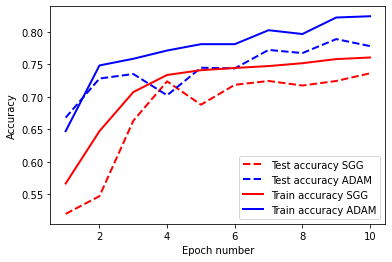

In [29]:
print(best_model)
plt.plot(range(1,11), model_results['sgd'][best_model['id']]['test_acc'], color='red', linestyle='dashed', linewidth=2)
plt.plot(range(1,11), model_results['adam'][best_model['id']]['test_acc'], color='blue', linestyle='dashed', linewidth=2)
plt.plot(range(1,11), model_results['sgd'][best_model['id']]['train_acc'], color='red', linewidth=2)
plt.plot(range(1,11), model_results['adam'][best_model['id']]['train_acc'], color='blue', linewidth=2)
plt.legend(('Test accuracy SGG','Test accuracy ADAM','Train accuracy SGG','Train accuracy ADAM'))
plt.xlabel('Epoch number')
plt.ylabel('Accuracy')
plt.show()

# Transfer Learning

## Train function

In [30]:
#We define the training as a function so we can easily re-use it.
def train(model, optimizer, criterion, num_epochs=10):
    out_dict = {'train_acc': [],
              'test_acc': [],
              'train_loss': [],
              'test_loss': []}
  
    for epoch in tqdm(range(num_epochs), unit='epoch'):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)
        model.train()
        #For each epoch
        train_correct = 0
        train_loss = []
        for minibatch_no, (data, target) in tqdm(enumerate(train_loader), total=len(train_loader)):
            data, target = data.to(device), target.to(device)
            #Zero the gradients computed for each weight
            optimizer.zero_grad()
            #Forward pass your image through the network
            output = model(data)
            #Compute the loss
            loss = criterion(output, target)
            #Backward pass through the network
            loss.backward()
            #Update the weights
            optimizer.step()

            train_loss.append(loss.item())
            #Compute how many were correctly classified
            predicted = output.argmax(1)
            train_correct += (target==predicted).sum().cpu().item()

        #Compute the test accuracy
        test_loss = []
        test_correct = 0
        model.eval()
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            with torch.no_grad():
                output = model(data)
            test_loss.append(criterion(output, target).cpu().item())
            predicted = output.argmax(1)
            test_correct += (target==predicted).sum().cpu().item()
            
        out_dict['train_acc'].append(train_correct/len(trainset))
        out_dict['test_acc'].append(test_correct/len(testset))
        out_dict['train_loss'].append(np.mean(train_loss))
        out_dict['test_loss'].append(np.mean(test_loss))
        print(f"Loss train: {np.mean(train_loss):.3f}\t test: {np.mean(test_loss):.3f}\t",
              f"Accuracy train: {out_dict['train_acc'][-1]*100:.1f}%\t test: {out_dict['test_acc'][-1]*100:.1f}%")

    return out_dict

## Build model

In [31]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
trans = transforms.Compose([transforms.Resize(256), 
                            transforms.CenterCrop(224), 
                            transforms.ToTensor(),
                            normalize
                            ])

In [32]:
batch_size = 64

trainset = Hotdog_NotHotdog(train=True, transform=trans)
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=3)
testset = Hotdog_NotHotdog(train=False, transform=trans)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=3)

In [33]:
# load model and observe its fully-connected (output) layer
resnet_152 = models.resnet152(pretrained=True)
resnet_152.fc

Linear(in_features=2048, out_features=1000, bias=True)

In [34]:
num_ftrs = resnet_152.fc.in_features
out_features = resnet_152.fc.out_features
print("# of input features:", num_ftrs)
print("# of output features:", out_features)

# of input features: 2048
# of output features: 1000


In [35]:
# freeze all the layers except from the last one
# Parameters of newly constructed modules have requires_grad=True by default
for param in resnet_152.parameters():
    param.requires_grad = False

# adjust fully connected layer to have just 2 features output (binary classification)
resnet_152.fc = nn.Linear(num_ftrs, 2)

# transfer model to gpu
resnet_152 = resnet_152.to(device)

# add loss function
criterion = nn.CrossEntropyLoss()

# Observe that all only the final layer parameters are being optimized
# optimizer_ft = torch.optim.SGD(resnet_152.fc.parameters(), lr=0.001, momentum=0.9)
optimizer_ft = torch.optim.Adam(resnet_152.fc.parameters(), lr=0.001)

# Decay LR by a factor of 0.1 every 7 epochs
# exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

## Train model

In [36]:
# train model
transfer_learning_results = train(resnet_152, optimizer_ft, criterion, num_epochs=7)

  0%|          | 0/7 [00:00<?, ?epoch/s]

Epoch 0/6
----------


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.353	 test: 0.219	 Accuracy train: 84.4%	 test: 90.3%
Epoch 1/6
----------


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.198	 test: 0.212	 Accuracy train: 92.1%	 test: 91.8%
Epoch 2/6
----------


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.164	 test: 0.159	 Accuracy train: 93.9%	 test: 93.6%
Epoch 3/6
----------


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.134	 test: 0.169	 Accuracy train: 95.3%	 test: 92.2%
Epoch 4/6
----------


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.161	 test: 0.137	 Accuracy train: 94.0%	 test: 94.4%
Epoch 5/6
----------


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.116	 test: 0.142	 Accuracy train: 96.0%	 test: 93.5%
Epoch 6/6
----------


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.111	 test: 0.135	 Accuracy train: 96.3%	 test: 93.8%


## Visualize predictions

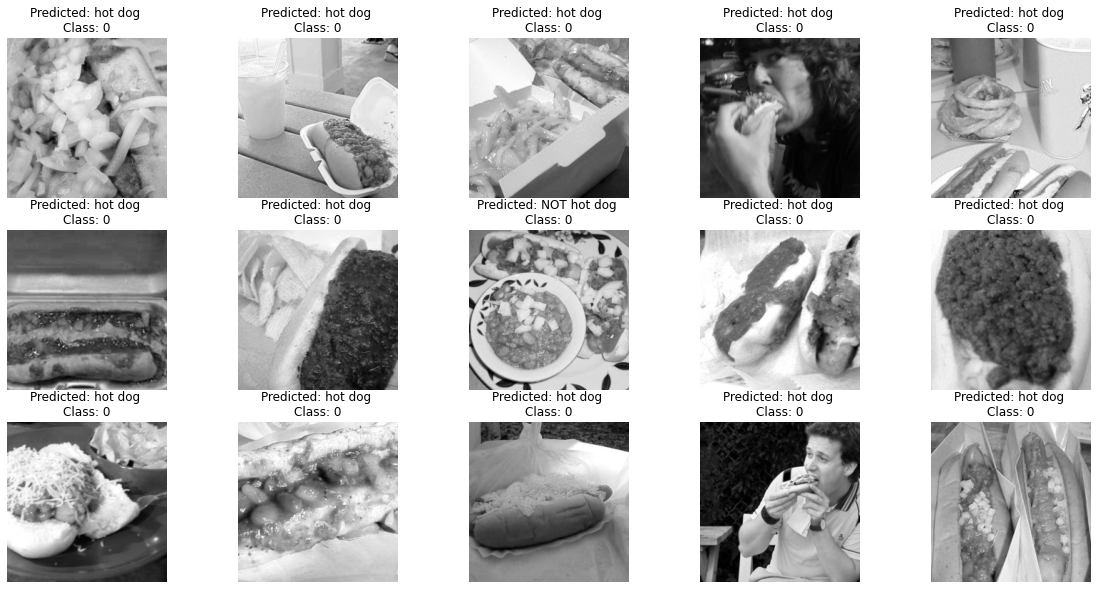

In [37]:
visualize_model(resnet_152)

# Saliency maps

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

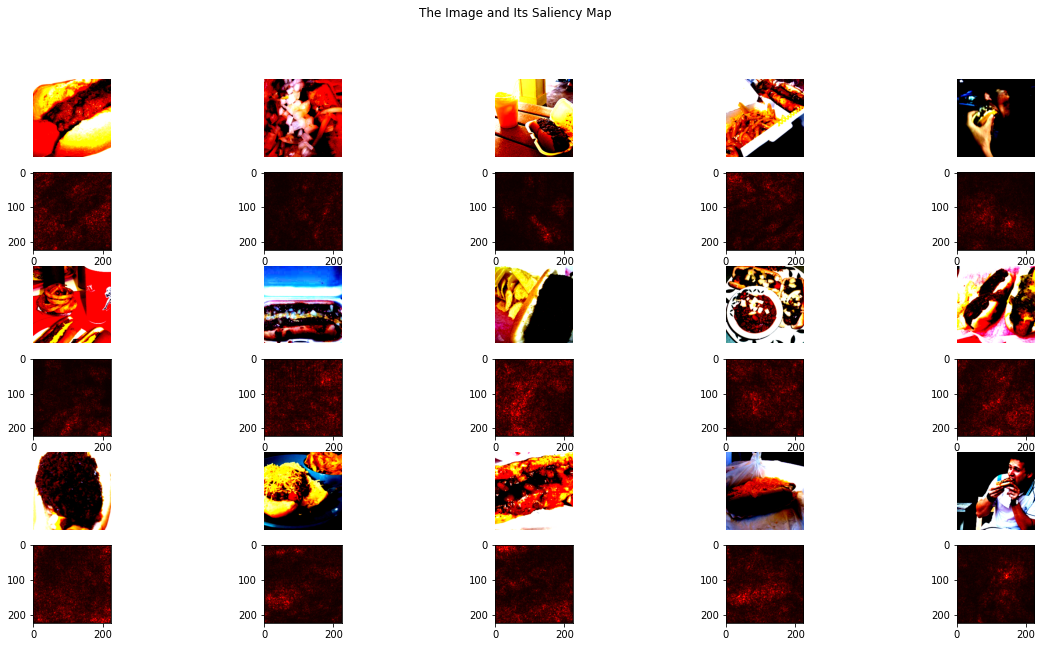

In [40]:
num_images = 15
for i, (inputs, labels) in enumerate(test_loader):
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs = resnet_152(inputs)
    _, preds = torch.max(outputs, 1)

    fig, axs = plt.subplots(6,5, figsize=(20,10))
    c = 0
    # plot 15 images in a grid 3x5
    for j in [0, 2, 4]:
        for k in range(5):
            # get the next image
            img = inputs.data[c]
            # Reshape the image (because the model use 
            # 4-dimensional tensor (batch_size, channel, width, height))
            img = img.reshape(1, 3, 224, 224)
            # Set the device for the image
            img = img.to(device)
            # Set the requires_grad_ to the image for retrieving gradients
            img.requires_grad_()

            # Retrieve output from the image
            output = resnet_152(img)

            # Catch the output
            output_idx = output.argmax()
            output_max = output[0, output_idx]

            # Do backpropagation to get the derivative of the output based on the image
            output_max.backward()

            # Retireve the saliency map and also pick the maximum value from channels on each pixel.
            # In this case, we look at dim=1. Recall the shape (batch_size, channel, width, height)
            saliency, _ = torch.max(img.grad.data.abs(), dim=1) 
            saliency = saliency.reshape(224, 224)

            # Reshape the image
            img = img.reshape(-1, 224, 224)

            # Visualize the image and the saliency map
            axs[j,k].imshow(img.cpu().detach().numpy().transpose(1, 2, 0))
            axs[j,k].axis('off')
            axs[j+1,k].imshow(saliency.cpu(), cmap='hot')
            axs[j,k].axis('off')

            # go to the next image
            c += 1

            if c == num_images:
                break

    # do this with just 1 batch
    if i == 0:
        break

# plt.tight_layout()
plt.suptitle('The Image and Its Saliency Map')
plt.show()

# The END